In [21]:
import glob, json, h5py, math, time, os
import numpy as np
import matplotlib.pyplot as plt

from NPLM.PLOTutils import *
from NPLM.ANALYSISutils import *
from NPLM.NNutils import *

In [103]:
def collect_final_set(file_history):
    f = h5py.File(file_history, 'r')
    final_set  = {}
    for key in list(f.keys()):
        final_set[key] = f[key][-1]
        print(key, f[key][-1])
    f.close()
    return final_set

# define folder

In [104]:
# input directory
jobs_folder = './out/toy/batch/Nbatches5/SHAPE1_nuN0_Nbkg400_Nsig0_epochsTau200000_epochsDelta30000_arc1_4_1_wclip9/'

# output directory
out_folder = jobs_folder+'/out/' # BKG-only experiments NU_S=0, NU_N=0.15, SIGMA_S=SIGMA_N=0.15
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

In [105]:
json_file = '%s/config.json'%(jobs_folder)
with open(json_file, 'r') as jsonfile:
    config_json = json.load(jsonfile)
    
TAU_architecture    = config_json['BSMarchitecture']
TAU_df              = compute_df(input_size=TAU_architecture[0], hidden_layers=TAU_architecture[1:-1])
TAU_wc              = config_json['BSMweight_clipping']
TAU_patience        = config_json['patience_tau']
DELTA_patience      = config_json['patience_delta']
N_Bkg               = config_json['N_Bkg']
N_Sig               = config_json['N_Sig']
N_ref               = config_json['N_Ref']
N_R        = N_ref
N_D        = N_Bkg
N_batches  = config_json["N_batches"]
correction = config_json["correction"]
#### training time                                                                                                                                                                                           
total_epochs_tau   = config_json["epochs_tau"]
patience_tau       = config_json["patience_tau"]
total_epochs_delta = config_json["epochs_delta"]
patience_delta     = config_json["patience_delta"]
#### architecture                                                                                                                                                                                            
BSMweight_clipping = config_json["BSMweight_clipping"]
BSMarchitecture    = config_json["BSMarchitecture"]
inputsize          = BSMarchitecture[0]
BSMdf              = compute_df(input_size=BSMarchitecture[0], hidden_layers=BSMarchitecture[1:-1])

# aggregation over batches

In [106]:
tau_list, delta_list = [], []
# loop over toys
for sub_f in [x[0] for x in os.walk(jobs_folder)]:
    if not 'seed' in sub_f: continue
    seed = int(sub_f.split('seed')[-1])
    if [len(x[2]) for x in os.walk(sub_f)][0]<6*N_batches:
        # not all batches are done, skip toy
        continue
    tau_tmp, delta_tmp = 0, 0
    laux_tau_tmp, laux_delta_tmp = 0, 0
    loss_tau_tmp, loss_delta_tmp = 0, 0
    norm_tau_tmp, norm_delta_tmp = 0, 0
    scale_delta_tmp, scale_tau_tmp = 0, 0
    # loop over batches
    for run in range(N_batches):
        # ratio of densities
        r_tau_tmp, r_delta_tmp = np.array([]), np.array([])
        #### nuisance parameters configuration                                                                                                                                                                       
        correction= config_json["correction"]
        NU_S, NUR_S, NU0_S, SIGMA_S = [], [], [], []
        NU_N, NUR_N, NU0_N, SIGMA_N = 0, 0, 0, 0
        shape_dictionary_list = []
        
        # this seed defines the aux values, has to be the same for all runs 
        np.random.seed(seed)                                                                                                                     
        if not correction=='':
            SIGMA_N   = config_json["norm_nuisances_sigma"]
            NU_N      = config_json["norm_nuisances_data"]*SIGMA_N
            NUR_N     = config_json["norm_nuisances_reference"]*SIGMA_N
            NU0_N     = np.random.normal(loc=NU_N, scale=SIGMA_N, size=1)[0]
        
        if correction=='SHAPE':
            SIGMA_S   = config_json["shape_nuisances_sigma"]
            NU_S      = [config_json["shape_nuisances_data"][i]*SIGMA_S[i] for i in range(len(SIGMA_S))]
            NUR_S     = [config_json["shape_nuisances_reference"][i]*SIGMA_S[i] for i in range(len(SIGMA_S))]
            NU0_S     = np.array([np.random.normal(loc=NU_S[i], scale=SIGMA_S[i], size=1)[0] for i in range(len(SIGMA_S))])
            shape_dictionary_list=config_json["shape_dictionary_list"]
        
        #### build batch samples ################### 
        # nuisance for generation
        Norm = NU_N
        Scale= NU_S[0]
        # ref                                                                                                                                                                                                        
        np.random.seed(seed) # this seed defines the reference, has to be the same for all runs                                                                                                                      
        featureRef  = np.random.exponential(scale=1., size=(N_ref, 1))
        # data                                                                                                                                                                                                       
        np.random.seed(seed+run) # this seed defines the pois and the data sampling, has to be differente for all runs                                                                                               
        N_Bkg_Pois  = np.random.poisson(lam=N_Bkg*np.exp(Norm), size=1)[0]
        if N_Sig:
            N_Sig_Pois = np.random.poisson(lam=N_Sig*np.exp(Norm), size=1)[0]
        
        featureData = np.random.exponential(scale=np.exp(1*Scale), size=(N_Bkg_Pois, 1))
        if N_Sig:
            featureSig  = np.random.normal(loc=6.4, scale=0.16, size=(N_Sig_Pois,1))*np.exp(Scale)
            featureData = np.concatenate((featureData, featureSig), axis=0)
        
        feature     = np.concatenate((featureData, featureRef), axis=0)

        # target                                                                                                                                                                                                     
        targetData  = np.ones_like(featureData)
        targetRef   = np.zeros_like(featureRef)
        weightsData = np.ones_like(featureData)
        weightsRef  = np.ones_like(featureRef)*N_D*1./N_R
        target      = np.concatenate((targetData, targetRef), axis=0)
        weights     = np.concatenate((weightsData, weightsRef), axis=0)
        target      = np.concatenate((target, weights), axis=1)
        inputsize   = feature.shape[1]
        # loop over the models to aggregate f(x, w)                                                                                                                                                       
        for batch_model in range(N_batches):
            OUTPUT_FILE_ID = 'run%i'%(batch_model)
            OUTPUT_PATH = sub_f+'/'
            #### TAU ###############################    
            # load the nuisance parameters final values after fit
            file_history=OUTPUT_PATH+OUTPUT_FILE_ID+'_TAU_history.h5'
            final_set = collect_final_set(file_history)
            NU_N = final_set['norm'][0]
            NU_S = final_set['shape']
            norm_tau_tmp +=NU_N/N_batches**2
            scale_tau_tmp +=NU_S/N_batches**2
            tau = imperfect_model(input_shape=(None, inputsize),
                              NU_S=NU_S, NUR_S=NUR_S, NU0_S=NU0_S, SIGMA_S=SIGMA_S,
                              NU_N=NU_N, NUR_N=NUR_N, NU0_N=NU0_N, SIGMA_N=SIGMA_N,
                              correction=correction, shape_dictionary_list=shape_dictionary_list,
                              BSMarchitecture=BSMarchitecture, BSMweight_clipping=BSMweight_clipping, train_f=True, train_nu=True)
            # load the model 
            log_weights = OUTPUT_PATH+OUTPUT_FILE_ID+'_TAU_weights.h5'
            tau.load_weights(log_weights)
            if r_tau_tmp.shape[0]==0:r_tau_tmp = np.exp(tau.predict(feature))/N_batches
            else:r_tau_tmp += np.exp(tau.predict(feature))/N_batches

            #### DELTA ###############################    
            # load the nuisance parameters final values after fit
            file_history=OUTPUT_PATH+OUTPUT_FILE_ID+'_DELTA_history.h5'
            final_set = collect_final_set(file_history)
            NU_N = final_set['norm'][0]
            NU_S = final_set['shape']
            norm_delta_tmp +=NU_N/N_batches**2
            scale_delta_tmp +=NU_S/N_batches**2
            delta = imperfect_model(input_shape=(None, inputsize),
                      NU_S=NU_S, NUR_S=NUR_S, NU0_S=NU0_S, SIGMA_S=SIGMA_S,
                      NU_N=NU_N, NUR_N=NUR_N, NU0_N=NU0_N, SIGMA_N=SIGMA_N,
                      correction=correction, shape_dictionary_list=shape_dictionary_list,
                      BSMarchitecture=BSMarchitecture, BSMweight_clipping=BSMweight_clipping, train_f=False, train_nu=True)
            # load the model 
            log_weights = OUTPUT_PATH+OUTPUT_FILE_ID+'_DELTA_weights.h5'
            delta.load_weights(log_weights)
            if r_delta_tmp.shape[0]==0:r_delta_tmp = np.exp(delta.predict(feature))/N_batches
            else:r_delta_tmp += np.exp(delta.predict(feature))/N_batches

            
        tau_tmp_batch = -2*NPLMloss(target, np.log(r_tau_tmp)).numpy()
        print('tau_tmp_batch', tau_tmp_batch)
        tau_tmp += tau_tmp_batch
        
        delta_tmp_batch = -2*NPLMloss(target, np.log(r_delta_tmp)).numpy()
        print('delta_tmp_batch', delta_tmp_batch)
        delta_tmp += delta_tmp_batch
        
        laux_tau_tmp = np.sum(-0.5*((norm_tau_tmp-NU0_N)**2 - (NUR_N-NU0_N)**2)/SIGMA_N**2 )
        laux_tau_tmp += tf.reduce_sum(-0.5*((scale_tau_tmp-NU0_S)**2 - (NUR_S-NU0_S)**2)/SIGMA_N**2 )
        
        laux_delta_tmp = np.sum(-0.5*((norm_delta_tmp-NU0_N)**2 - (NUR_N-NU0_N)**2)/SIGMA_N**2 )
        laux_delta_tmp += tf.reduce_sum(-0.5*((scale_delta_tmp-NU0_S)**2 - (NUR_S-NU0_S)**2)/SIGMA_N**2 )
    tau_list.append(tau_tmp+laux_tau_tmp)
    delta_list.append(delta_tmp+laux_delta_tmp)
    print('seed: ', seed, ', tau: ', tau_list[-1], 'delta: ', delta_list[-1])

epoch 199001
laux 0.026293691
loss -6.9611216
norm [0.00497002]
shape [-0.01230426]
1262/1262 [==============================] - 1s 302us/step
epoch 29001
laux -0.5084276
loss -1.0660167
norm [-0.04657093]
shape [-0.00586797]
1262/1262 [==============================] - 0s 291us/step
epoch 199001
laux -0.012372719
loss -2.9967024
norm [0.00496555]
shape [-0.02453003]
1262/1262 [==============================] - 0s 302us/step
epoch 29001
laux -0.09183729
loss -0.26871455
norm [-0.01923155]
shape [-0.01344774]
1262/1262 [==============================] - 0s 293us/step
epoch 199001
laux 0.026658125
loss -3.8955028
norm [0.00495179]
shape [-0.01176093]
1262/1262 [==============================] - 0s 304us/step
epoch 29001
laux -0.001296155
loss -0.007693
norm [-0.0033956]
shape [-0.00204445]
1262/1262 [==============================] - 0s 298us/step
epoch 199001
laux 0.023738476
loss -4.9824
norm [0.00495936]
shape [-0.01451073]
1262/1262 [==============================] - 0s 302us/step
ep

TypeError: loop of ufunc does not support argument 0 of type RaggedTensor which has no callable exp method

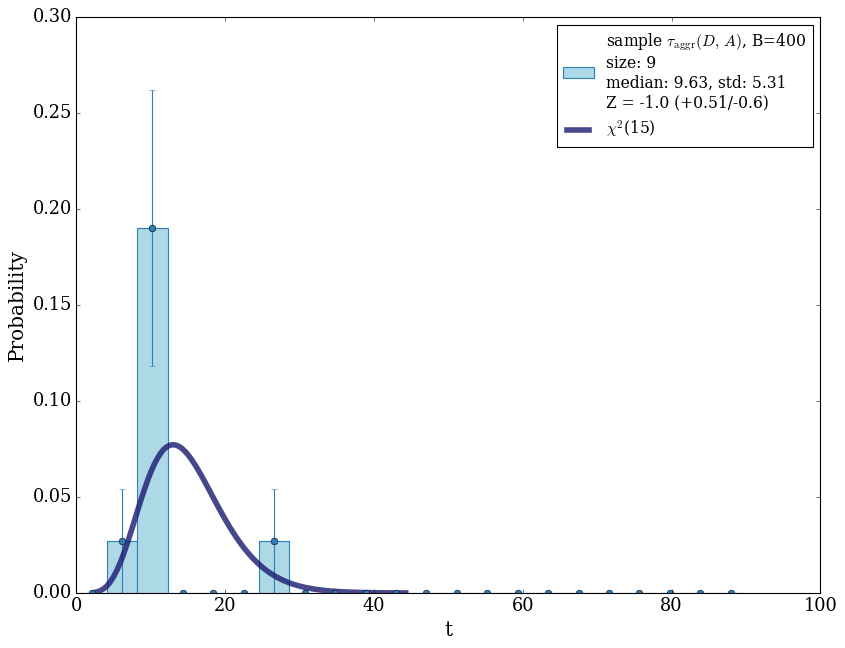

In [107]:
label = 'B=%i'%(N_Bkg)
if N_Sig: label += ', S=%i'%(N_Sig)
    
plot_1distribution(np.array(tau_list), df=TAU_df+2, xmin=0, xmax=90, nbins=22, label=r'$\tau_{\rm aggr}(D,\,A)$, '+label, save=False, save_path='', file_name='')


/Users/gaiagrosso/Dropbox/NPLM-batch/1D-EXPO/systematic-uncertainties/NPLM/PLOTutils.py:115: RuntimeWarning: invalid value encountered in scalar subtract
  label += 'Z = %s (+%s/-%s)'%(str(np.around(Z_obs, 2)), str(np.around(Z_obs_p-Z_obs, 2)), str(np.around(Z_obs-Z_obs_m, 2)))


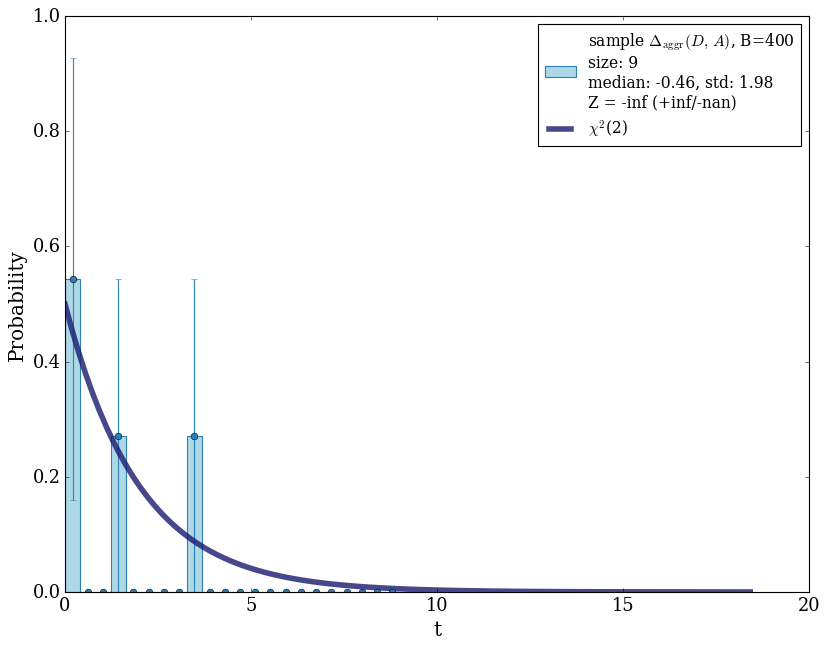

In [108]:
label = 'B=%i'%(N_Bkg)
if N_Sig: label += ', S=%i'%(N_Sig)
    
plot_1distribution(np.array(delta_list), df=2, xmin=0, xmax=9, nbins=22, label=r'$\Delta_{\rm aggr}(D,\,A)$, '+label, save=False, save_path='', file_name='')


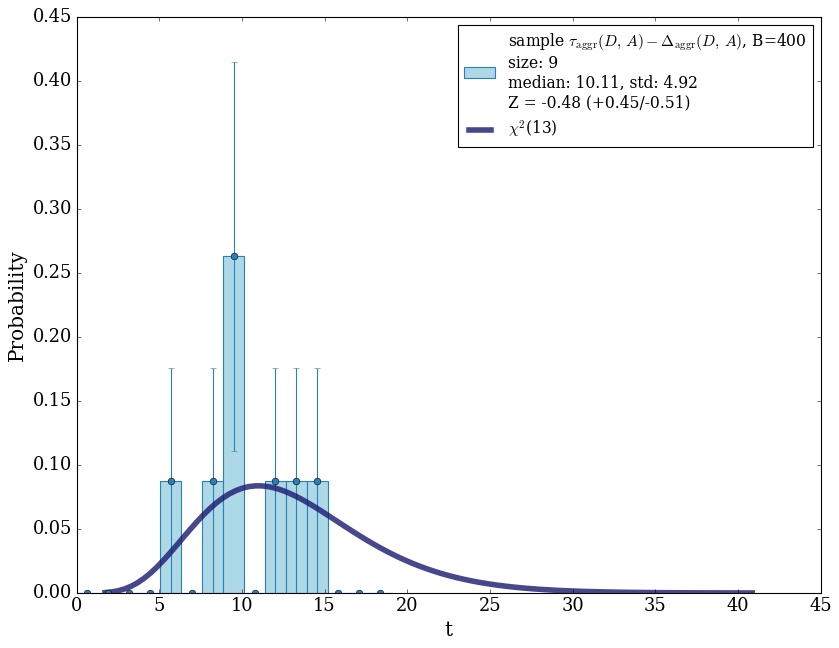

In [109]:
label = 'B=%i'%(N_Bkg)
if N_Sig: label += ', S=%i'%(N_Sig)
    
plot_1distribution(np.array(tau_list)-np.array(delta_list), df=TAU_df, xmin=0, xmax=19, nbins=15, label=r'$\tau_{\rm aggr}(D,\,A)-\Delta_{\rm aggr}(D,\,A)$, '+label, save=False, save_path='', file_name='')

# per batch output analysis

In [97]:
tau_batch_list, delta_batch_list = np.array([]), np.array([])
evol_TAU, evol_DELTA = {}, {}
keys = ['loss', 'laux', 'norm', 'shape']
for k in keys:
    evol_TAU[k]=np.array([])
    evol_DELTA[k]=np.array([])
for sub_f in [x[0] for x in os.walk(jobs_folder)]:
    if not 'seed' in sub_f: continue
    values = collect_txt(DIR_IN=sub_f, suffix='TAU', files_prefix=[],  verbose=False)
    tau_batch_list = np.append(tau_batch_list, values)
    if not correction=='':
        values = collect_txt(DIR_IN=sub_f, suffix='DELTA', files_prefix=[],  verbose=False)
        delta_batch_list = np.append(delta_batch_list, values)
    OUTPUT_FILE_ID_list = ['/run%i'%(run) for run in range(N_batches)]
    for k in keys:
        key_history = collect_history(OUTPUT_FILE_ID_list, DIR_IN=sub_f, suffix='_TAU', key=k, verbose=False)
        if k in ['norm', 'shape']: key_history=key_history[0, :, :]
        if evol_TAU[k].shape[0]==0: evol_TAU[k] = key_history
        else: evol_TAU[k] = np.concatenate((evol_TAU[k], key_history), axis=0)
        if not correction=='':
            key_history = collect_history(OUTPUT_FILE_ID_list, DIR_IN=sub_f, suffix='_DELTA', key=k, verbose=False)
            if k in ['norm', 'shape']: key_history=key_history[0, :, :]
            if evol_DELTA[k].shape[0]==0: evol_DELTA[k] = key_history
            else: evol_DELTA[k] = np.concatenate((evol_DELTA[k], key_history), axis=0)
        

18.1686
13.922243
5.993405
9.9648
7.791006
0.180806
0.015386
1.972259
0.537429
2.132033
12.90659
15.549826
21.012955
11.243866
12.117178
1.593035
1.423718
1.055092
0.345951
2.522266
13.475174
16.609224
12.26196
20.098022
16.925594
3.853893
3.379477
1.818869
3.203813
1.929445
11.446452
4.942768
11.570996
15.110027
9.588091
1.877502
2.188141
1.120274
0.872896
1.120851
10.923086
11.436087
13.170415
6.984193
20.591944
1.776532
2.331842
2.941344
2.22651
2.285095
11.992213
8.55303
10.18646
4.769904
9.828828
0.036411
2.315846
0.766482
0.249729
0.832442
24.123037
7.325352
13.823992
9.690639
16.75676
0.72089
4.84266
0.544576
0.187366
1.297721
13.70595
10.917535
14.167261
12.154889
8.576834
0.739391
3.415016
3.408374
0.188964
0.164606
13.398071
18.243839
14.79493
6.34461
13.408843
3.154722
0.077146
6.489415
0.729391
2.418175
7.720234
6.463983
6.912585
8.474354
6.264537
0.297888
0.89396
0.366402
0.271389
1.328019
16.292652
17.928852
7.564128
6.492516
17.112497
0.140757
2.044866
5.264473
0.860242


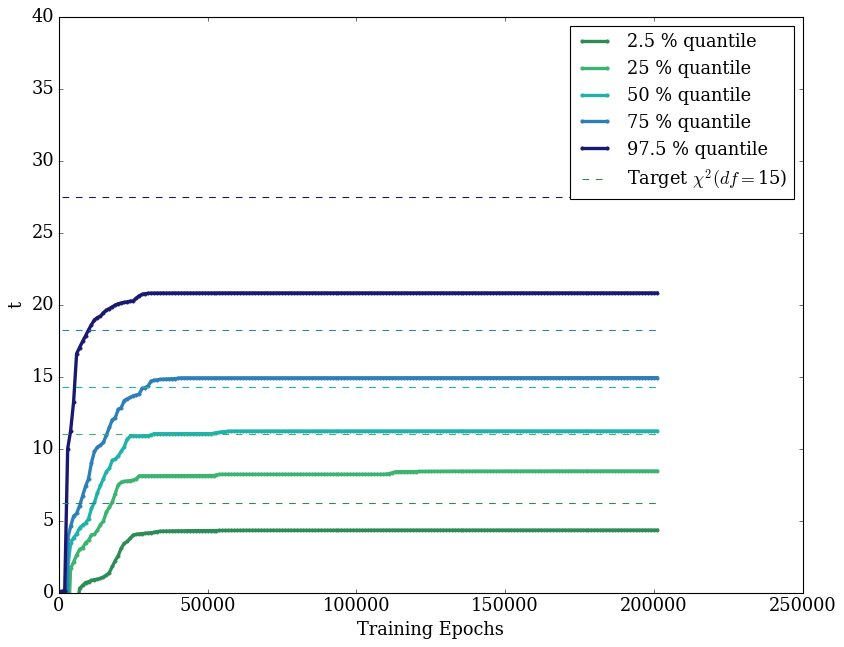

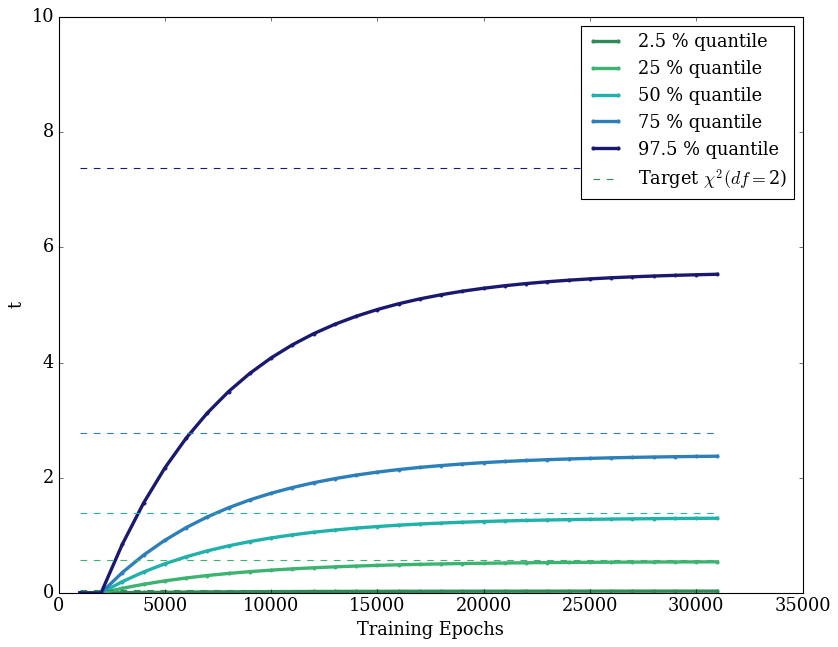

In [98]:
k='loss'
Plot_Percentiles_ref(evol_TAU[k], df=TAU_df+2, patience=TAU_patience, wc=None, ymax=40, ymin=0, save=False, save_path='', file_name='')
if not correction=='':
    Plot_Percentiles_ref(evol_DELTA[k], df=2, patience=DELTA_patience, wc=None, ymax=10, ymin=0, save=False, save_path='', file_name='')


(201, 5)


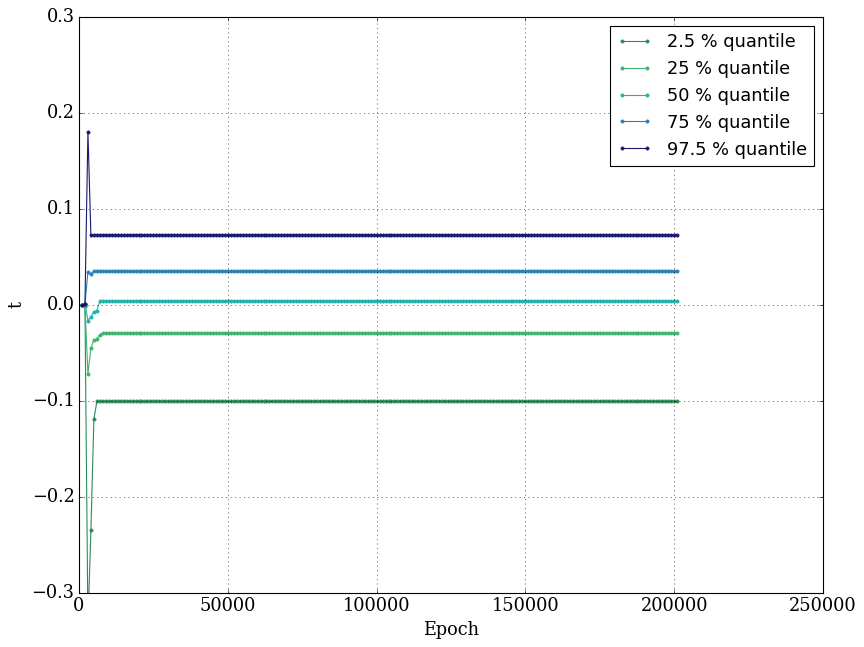

(31, 5)


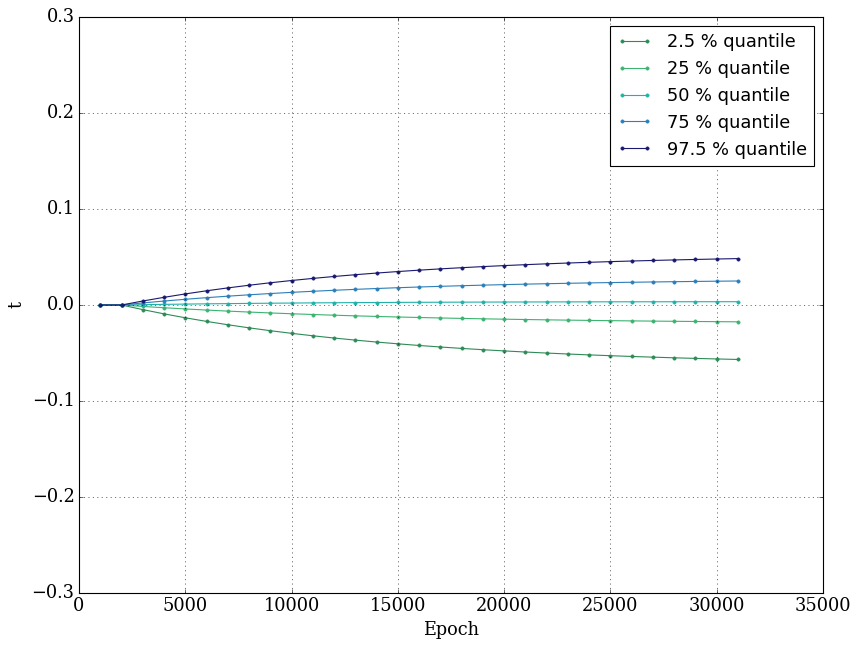

In [99]:
k='norm'
Plot_Percentiles(evol_TAU[k], patience=TAU_patience, ymax=0.3, ymin=-0.3, save=False, save_path='', file_name='')
if not correction=='':
    Plot_Percentiles(evol_DELTA[k], patience=DELTA_patience, ymax=0.3, ymin=-0.3, save=False, save_path='', file_name='')


(201, 5)


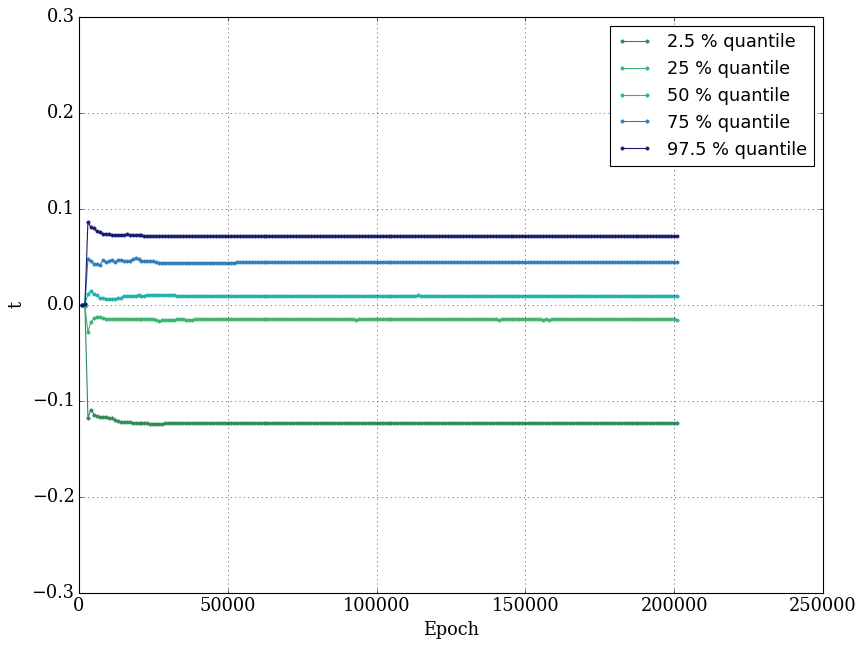

(31, 5)


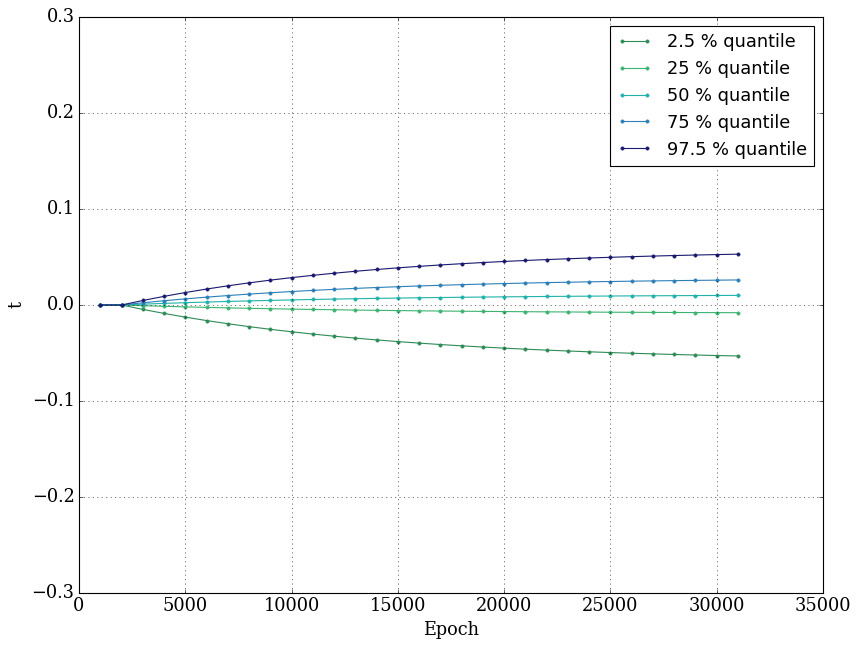

In [100]:
k='shape'
Plot_Percentiles(evol_TAU[k], patience=TAU_patience, ymax=0.3, ymin=-0.3, save=False, save_path='', file_name='')
if not correction=='':
    Plot_Percentiles(evol_DELTA[k], patience=DELTA_patience, ymax=0.3, ymin=-0.3, save=False, save_path='', file_name='')


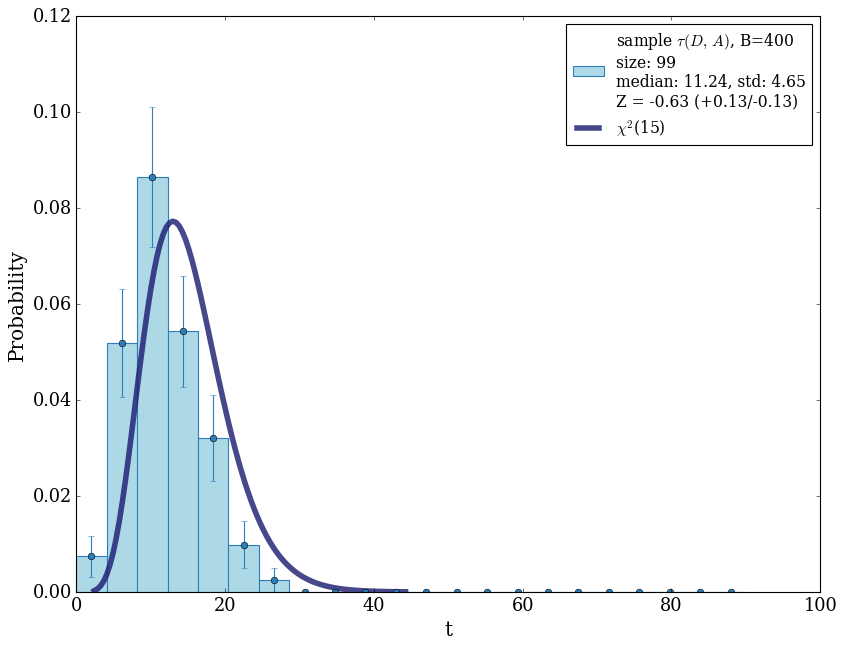

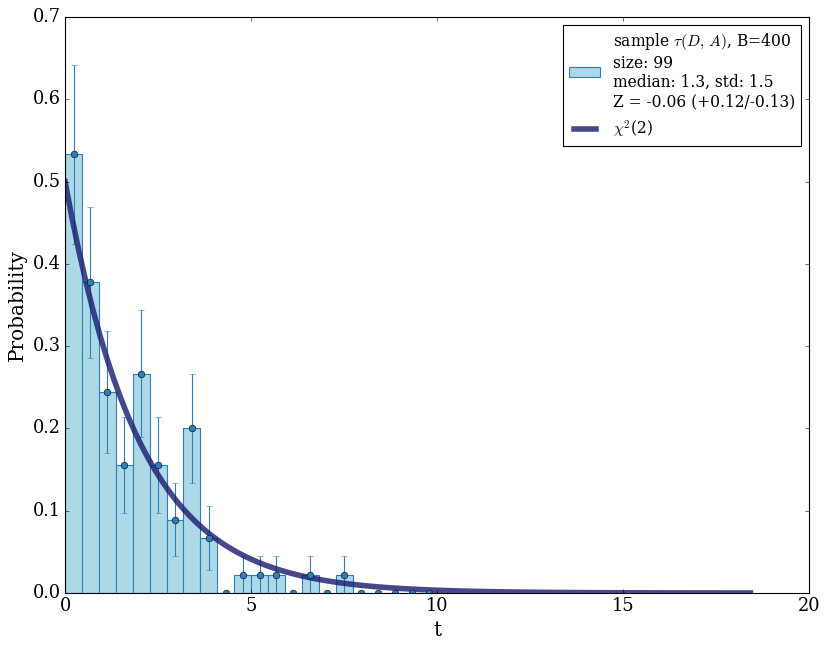

In [101]:
label = 'B=%i'%(N_Bkg)
if N_Sig: label += ', S=%i'%(N_Sig)
    
plot_1distribution(tau_batch_list, df=TAU_df+2, xmin=0, xmax=90, nbins=22, label=r'$\tau(D,\,A)$, '+label, save=False, save_path='', file_name='')
plot_1distribution(delta_batch_list, df=2, xmin=0, xmax=10, nbins=22, label=r'$\tau(D,\,A)$, '+label, save=False, save_path='', file_name='')


In [48]:
def collect_txt(DIR_IN, suffix='t', files_prefix=[],  verbose=False):
    '''
    For each toy the function reads the .txt file where the final value for the variable t=-2*loss is saved. 
    It then associates a label to each toy.
    The array of the t values (tvalues) and the array of labels (files_id) are saved in an .h5 file.
    
    DIR_IN: directory where all the toys' outputs are saved
    DIR_OUT: directory where to save the .h5 output file
    
    The function returns the array of labels.
    '''
    dt = h5py.special_dtype(vlen=str)
    tvalues, files_id, seeds = np.array([]), np.array([]), np.array([])
    if len(files_prefix)>0:
        if verbose:
            print('use given files_prefix list')
    for fileIN in glob.glob("%s/*_%s.txt" %(DIR_IN, suffix) ):
        keep_file = True
        if len(files_prefix)>0:
            keep_file = False
            for f in files_prefix:
                if f in fileIN:
                    keep_file=True
                    break
            if not keep_file:
                continue
        f = open(fileIN)
        lines = f.readlines()
        #file_id=  fileIN.split('/')[-1]
        #seed = file_id.split('seed')[1]
        #seed = int(seed.split('_')[0])

        #file_id = file_id.replace('_%s.txt'%(suffix), '')
        f.close()
        if len(lines)==0:
            if verbose: print('empty')
            continue
        t = float(lines[0])
        if(np.isnan(np.array([t]))):
            if verbose: print('nan')
            t = -1
        print(t)
        tvalues  = np.append(tvalues, t)
        #files_id = np.append(files_id, file_id)
        #seeds    = np.append(seeds, seed)
    
    #files_id=np.array(files_id, dtype=dt)
    if tvalues.shape[0]==0:
        print('Empty folder')
    return tvalues#, files_id, seeds